In [1]:
import math
import cv2
import os
import numpy as np
import time
import random
import torch
import re
import torch.nn as nn
import torchvision
import torchvision.models as models
import torch.autograd as autograd
import torch.optim as optim
from torchvision import datasets,models,transforms,utils
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from PIL import Image, ImageEnhance
import torchvision.transforms.functional as TF
import csv
import matplotlib.pyplot as plt
import json
import copy
from torch.optim import lr_scheduler
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
class Objectdataset(Dataset):

    def __init__(self, folder_dir, transform=None):

        self.folder_dir = folder_dir
        self.transform = transform
        self.image_list=[]
        for folder in os.listdir(self.folder_dir):
          dir_list = os.listdir(self.folder_dir+folder)
          for item in dir_list:
            name=folder+'/'+item.split(".")[0]
            if name not in self.image_list:
              self.image_list.append(name)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        timestamp=self.image_list[idx]
        
        image = np.load(self.folder_dir+timestamp+'.npy')
        image = image[80:,110:570,:]
        image[:,:,0]=np.interp(image[:,:,0], (image[:,:,0].min(), image[:,:,0].max()), (0, 255))
        image[:,:,1]=np.interp(image[:,:,1], (image[:,:,1].min(), image[:,:,1].max()), (0, 255))
        image[:,:,2]=np.interp(image[:,:,2], (image[:,:,2].min(), image[:,:,2].max()), (0, 255))
        #image = np.repeat(image[..., np.newaxis], 3, axis=2)
        image = Image.fromarray(np.uint8(image))

        f = open(self.folder_dir+timestamp+'.json')
        labels = json.load(f)
        f.close()
        #label = np.array(labels['position_above'])
        label = np.array(labels['position_above'][0:2])

        if self.transform:
            image = self.transform(image)

        #sample = {'image': image, 'label': label}

        return image, label

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Pad(padding=[0,30,0,30]),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Pad(padding=[0,30,0,30]),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

objectdataset = {x: Objectdataset(folder_dir="/content/drive/MyDrive/amazon-RL/dataset1_cylinder/"+x+'/',transform=data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(objectdataset[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'val']}

In [ ]:
# RESNET 50

class net(nn.Module):

		def __init__(self):
			super(net,self).__init__()
	
			resnet = models.resnet50(pretrained=True)
			
			modules = list(resnet.children())[:-1]
			self.resnet = nn.Sequential(*modules)
			self.linear1 = nn.Linear(resnet.fc.in_features, 512)
			
			#self.bn1 = nn.BatchNorm1d(512, momentum=0.01)
			self.activation1 = nn.Tanh()
			
			#self.linear2 = nn.Linear(512, 256)
			#self.bn2 = nn.BatchNorm1d(256, momentum=0.01)
			#self.relu2 = nn.ReLU()
			
			self.linear3 = nn.Linear(512, 6)

		
		def forward(self,x):
			with torch.no_grad():
				features = self.resnet(x)

			features = features.reshape(features.size(0), -1)
			features = self.activation1(self.linear1(features))
			#features = self.relu2(self.bn2(self.linear2(features)))
			features = self.linear3(features)
			
			return features

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_conv = net().to(device)

criterion = nn.MSELoss()

optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
#optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

In [ ]:
# onelayer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

criterion = nn.MSELoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# 5 layer CNN

class block(torch.nn.Module):
    def __init__(self, channel, kernel_size, stride):
        super().__init__()
        
        self.stride = stride
        # layers
        self.conv1 = nn.Conv2d(channel[0], channel[1], kernel_size, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(channel[1])
        self.conv2 = nn.Conv2d(channel[1], channel[1], kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(channel[1])
        
        self.relu = nn.Tanh()
        
        self.downsample = nn.Sequential(
            nn.Conv2d(channel[0], channel[1], 1, stride=2),
            nn.BatchNorm2d(channel[1])
        )
        
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.stride != 1:
            identity = self.downsample(identity)
            
        out += identity

        return self.relu(out)

class CNN(torch.nn.Module):
    def __init__(self, channels, kernel_sizes, stride):
        # channels: list of numbers
        # kernel_sizes: list of numbers
        # stride: list of numbers
        super().__init__()
        
        # layers
        self.layers = nn.Sequential()
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        
        for i in range(len(kernel_sizes)):
            self.layers.append(block(channels[i:i+2],kernel_sizes[i],stride[i]))
        
    def forward(self, x):
        
        x = self.layers(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_conv = CNN([3,16,16,16,16,6,6],[3,3,3,3,3,3],[2,1,2,1,2,1]).to(device)

criterion = nn.MSELoss()

#optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=15, gamma=0.1)

In [4]:
## PointNet

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,256,1)
      self.fc1 = nn.Linear(256,k*k)
      self.activation = nn.Tanh()
      
      
   def forward(self, input):
      bs = input.size(0)
      xb = self.activation(self.conv1(input)) 
      #print("xb",xb.shape)     
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      #print("flat",flat.shape)

      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc1(flat).view(-1,self.k,self.k) + init
      return matrix

class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)
        #self.conv2 = nn.Conv1d(64,128,1)
        self.activation = nn.Tanh()

       
   def forward(self, input):

        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication        
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)
        #print("xb111.shape",xb.shape)        
        xb = self.activation(self.conv1(xb))
        #print("xb222.shape",xb.shape)
        matrix64x64 = self.feature_transform(xb)
        #print("matrix64x64.shape",matrix64x64.shape)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)
        #print("xb333.shape",xb.shape)
       
        #xb = self.activation(self.conv2(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        #print("xb555.shape",xb.shape)

        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64


class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(64, 2)
        #self.fc2 = nn.Linear(512, 256)
        #self.fc3 = nn.Linear(256, classes)

        #self.bn1 = nn.BatchNorm1d(512)
        #self.bn2 = nn.BatchNorm1d(256)
        #self.dropout = nn.Dropout(p=0.3)
        #self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        input = torch.reshape(input,(input.shape[0], 3, 460*460))
        xb, matrix3x3, matrix64x64 = self.transform(input)
        #print("xb",xb.shape)
        xb = self.fc1(xb)
        #xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        #output = self.fc3(xb)      
        #return self.logsoftmax(output), matrix3x3, matrix64x64
        return xb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_conv = PointNet().to(device)

criterion = nn.MSELoss()

#optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=15, gamma=0.1)

In [5]:
def abs_dis(pred,truth):
  diff=pred-truth
  square_sum = diff[:,0]**2+diff[:,1]**2
  loss = torch.mean(square_sum**0.5)
  return loss

#pred=torch.tensor([[1, 2],[3, 4],[5, 6],[7, 8]]).to(device).float()
#truth=torch.tensor([[0, 2],[5, 5],[5, 6],[8, 8]]).to(device).float()
#ddd=abs_dis(pred,truth)
#print(ddd)

In [6]:
x = torch.rand(4,3,460,460).to(device).float()
y1 = model_conv(x)
print(y1)
#y2 = torch.tensor([[1, 2],[-0.0087, -0.2983],[-0.0073, -0.2963],[-0.0054, -0.2933]]).to(device).float()
#print(criterion(y1,y2))

tensor([[ 0.6538, -0.2056],
        [ 0.6523, -0.2025],
        [ 0.6554, -0.2024],
        [ 0.6555, -0.1985]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=45):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss=[]
    val_loss=[]


    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device).float()
                labels = labels.to(device).float()

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if phase == 'train':
                      #loss = criterion(outputs, labels)
                      loss = abs_dis(outputs, labels)
                    if phase == 'val':
                      loss = abs_dis(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(objectdataset[phase])
            
            if phase == 'train':
              train_loss.append(epoch_loss)
            if phase == 'val':
              val_loss.append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f}')

            # deep copy the model
            if phase == 'val' and epoch==num_epochs-1:

                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # save and load best model weights
    ctime=time.strftime('%Y-%b-%d-%H-%M-%S-%Z')
    torch.save(best_model_wts, '/content/drive/MyDrive/Colab Notebooks/amazon-rl/saved_model/'+ctime+'-model.pt')
    np.save('/content/drive/MyDrive/Colab Notebooks/amazon-rl/saved_model/'+ctime+'-train.npy', np.array(train_loss))
    np.save('/content/drive/MyDrive/Colab Notebooks/amazon-rl/saved_model/'+ctime+'-val.npy', np.array(val_loss))

    model.load_state_dict(best_model_wts)
    return model, train_loss, val_loss

In [8]:
model_conv, train_losses, val_losses = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=55)

Epoch 0/54
----------
train Loss: 0.9106
val Loss: 0.3345

Epoch 1/54
----------
train Loss: 0.1949
val Loss: 0.0613

Epoch 2/54
----------
train Loss: 0.0916
val Loss: 0.0911

Epoch 3/54
----------
train Loss: 0.1315
val Loss: 0.1345

Epoch 4/54
----------
train Loss: 0.0889
val Loss: 0.0868

Epoch 5/54
----------
train Loss: 0.0808
val Loss: 0.1019

Epoch 6/54
----------
train Loss: 0.0862
val Loss: 0.0638

Epoch 7/54
----------
train Loss: 0.0593
val Loss: 0.0457

Epoch 8/54
----------
train Loss: 0.0499
val Loss: 0.0724

Epoch 9/54
----------
train Loss: 0.0527
val Loss: 0.0611

Epoch 10/54
----------
train Loss: 0.0502
val Loss: 0.0447

Epoch 11/54
----------
train Loss: 0.0653
val Loss: 0.0816

Epoch 12/54
----------
train Loss: 0.0482
val Loss: 0.0421

Epoch 13/54
----------
train Loss: 0.0380
val Loss: 0.0339

Epoch 14/54
----------
train Loss: 0.0356
val Loss: 0.0551

Epoch 15/54
----------
train Loss: 0.0335
val Loss: 0.0277

Epoch 16/54
----------
train Loss: 0.0167
val Loss

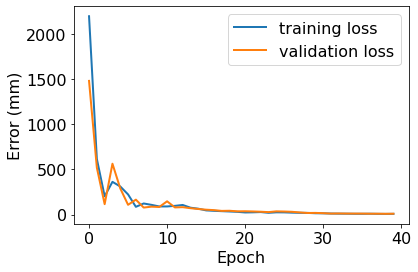

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
f = plt.figure(figsize=(6, 4))
#plt.title('Losses Plot')
plt.plot(np.array(train_losses[:40])*1000, label="training loss",linewidth=2)
plt.plot(np.array(val_losses[:40])*1000, label="validation loss",linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Error (mm)')

plt.legend()
plt.show()

In [ ]:
running_loss=0
i=0
model_conv.eval()

for inputs, labels in dataloaders['val']:
    print(i)
    inputs = inputs.to(device).float()
    labels = labels.to(device).float()

    optimizer_conv.zero_grad()
    outputs = model_conv(inputs)
    
    #print(inputs)
    print("ground truth:",labels)
    print("prediction:",outputs)
    #loss = criterion(outputs, labels)
    #running_loss += loss.item() * inputs.size(0)
    i=i+1

    break

#epoch_loss = running_loss / len(objectdataset['val'])


0
ground truth: tensor([[ 0.7700, -0.0500],
        [ 0.6400, -0.0360],
        [ 0.7360, -0.1800],
        [ 0.6570, -0.0700]], device='cuda:0')
prediction: tensor([[ 0.7682, -0.0534],
        [ 0.6370, -0.0357],
        [ 0.7408, -0.1865],
        [ 0.6520, -0.0664]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
running_loss=0
i=0
abc=PointNet().to(device)
abc.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/amazon-rl/saved_model/2022-Nov-29-21-38-33-UTC-model.pt"))

for inputs, labels in dataloaders['val']:
    print(i)
    inputs = inputs.to(device).float()
    labels = labels.to(device).float()

    optimizer_conv.zero_grad()
    outputs = abc(inputs)
    
    #print(inputs)
    print("ground truth:",labels)
    print("prediction:",outputs)
    #loss = criterion(outputs, labels)
    #running_loss += loss.item() * inputs.size(0)
    i=i+1

    break

#epoch_loss = running_loss / len(objectdataset['val'])

0
ground truth: tensor([[ 0.7700, -0.0500],
        [ 0.7570, -0.0160],
        [ 0.6150, -0.0940],
        [ 0.6400, -0.0360]], device='cuda:0')
prediction: tensor([[ 0.7682, -0.0534],
        [ 0.7625, -0.0200],
        [ 0.6191, -0.0891],
        [ 0.6370, -0.0357]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
import pandas as pd

def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change "num_workers" to 0.

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'][i_batch],
          sample_batched['label'][i_batch])
    
    t_np = sample_batched['image'][i_batch].numpy() #convert to Numpy array
    df = pd.DataFrame(t_np[0])
    print(df)
    break

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure(figsize=(18, 12))
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

0 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]) tensor([ 0.6000, -0.0680,  0.0900,  2.2141,  2.2222,  0.0000],
       dtype=torch.float64)
     0    1    2    3    4    5    6    7    8    9    ...  450  451  452  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
455  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
456  0.0  0.0  0.0  0.0  0.0 

In [ ]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/amazon-rl/testfile.csv",index=False)

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,450,451,452,453,454,455,456,457,458,459
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
transform = transforms.Compose(
	[transforms.ToTensor(),
	 transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
   transforms.Grayscale(), 

0 [ 0.662  -0.045   0.09    2.2141  2.2222  0.    ]
1 [ 0.71   -0.17    0.09    2.2141  2.2222  0.    ]
2 [ 0.775  -0.09    0.09    2.2141  2.2222  0.    ]
3 [ 0.678  -0.05    0.09    2.2141  2.2222  0.    ]


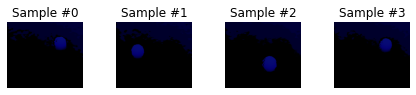

In [ ]:
face_dataset = Objectdataset(folder_dir="/content/drive/MyDrive/amazon-RL/dataset/")

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(i,  sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

In [ ]:
len(face_dataset.image_list)

47

In [ ]:
files= "/content/drive/MyDrive/amazon-RL/dataset/"

image_list=[]
for folder in os.listdir(files):
  dir_list = os.listdir(files+folder)
  for item in dir_list:
    name=item.split(".")[0]
    if name not in image_list:
      image_list.append(folder+'/'+name)


[[51.59273355 51.69812728 51.8035227  ... 64.23300692 64.34147945
  62.3606552 ]
 [50.90789654 51.01311026 51.11832397 ... 69.6657063  67.67904252
  67.78697163]
 [50.23283697 50.33786899 50.44290101 ... 70.93856532 71.04595102
  71.15333671]
 ...
 [31.51628941 31.51628941 31.51628941 ... 22.49126876 22.54921723
  22.6071657 ]
 [31.51628941 31.51628941 31.51628941 ... 20.91757991 20.97552838
  21.03347685]
 [31.51628941 31.51628941 31.51628941 ... 19.34386823 19.40181669
  19.45976516]]
(400, 460, 3)


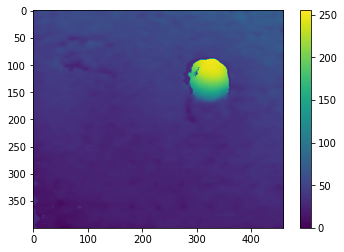

In [ ]:
import numpy as np

abc=np.load('/content/drive/MyDrive/amazon-RL/dataset/observations-frustum/trajectory-2022-Oct-07-15-33-17-PDT.npy')

z = abc[80:,110:570,:]

z[:,:,0]=np.interp(z[:,:,0], (z[:,:,0].min(), z[:,:,0].max()), (0, 255))
z[:,:,1]=np.interp(z[:,:,1], (z[:,:,1].min(), z[:,:,1].max()), (0, 255))
z[:,:,2]=np.interp(z[:,:,2], (z[:,:,2].min(), z[:,:,2].max()), (0, 255))

print(z[:,:,2])

print(z.shape)
c = plt.imshow(z[:,:,2])
plt.colorbar(c)

In [ ]:
with open('/content/drive/MyDrive/amazon-RL/dataset/observations-frustum/trajectory-2022-Oct-07-15-33-17-PDT.json', 'r') as f:
  data = json.load(f)

data

{'position_above': [0.662, -0.045, 0.09, 2.2141, 2.2222, 0],
 'position_below': [0.662, -0.045, 0.03, 2.2141, 2.2222, 0],
 'voltage': 1}

In [ ]:
f = open('/content/drive/MyDrive/amazon-RL/dataset/observations-frustum/trajectory-2022-Oct-07-15-33-17-PDT.json')
data1 = json.load(f)
f.close()

data1['position_above']

[0.662, -0.045, 0.09, 2.2141, 2.2222, 0]